In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Mar 27 04:24:54 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 27 04:24:54 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 1) #downsizing image
height,width = X.shape #getting height and width of image

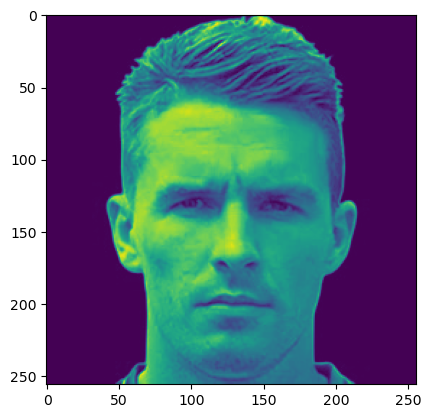

In [3]:
plt.imshow(X)

In [4]:
Y = np.fft.fft2(X)

In [5]:
width, height = Y.shape
Y.shape

(256, 256)

In [6]:
n = 12
yul = Y[:n, :n]
yur = Y[:n, -n:]
yll = Y[-n:, :n]
ylr = Y[-n:, -n:]



Z = np.block([[yul, yur],
              [yll, ylr]])     
Z.shape

(24, 24)

In [7]:
z = Z.flatten()
z = z.reshape((-1, 1))
z.shape

(576, 1)

In [8]:
A = np.random.randint(0,2,size=(z.shape[0],4*n**2))
A.shape

(576, 576)

In [9]:
b = A@z

In [10]:
error_threshold = 1e-8

w_real = cvx.Variable(4*n**2)
w_real = w_real.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(w_real, 1))
constraints = [cvx.norm(A@w_real - b.real,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()


w_image = cvx.Variable(4*n**2)
w_image = w_image.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(w_image, 1))
constraints = [cvx.norm(A@w_image - b.imag,2) <= error_threshold]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [11]:
w_sparse = w_real.value + w_image.value*1j

In [12]:
np.count_nonzero(w_sparse.real.round(8))

576

In [13]:
W = w_sparse.reshape((2*n,2*n))
W.shape

(24, 24)

In [14]:
Y_hat = np.zeros(width*height)
Y_hat = Y_hat.reshape((width,height))
Y_hat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
Y_hat[:n, :n] = W[:n, :n] #upper left
Y_hat[:n, -n:] = W[:n, -n:] #upper right
Y_hat[-n:, :n] = W[-n:, :n] #lower left
Y_hat[-n:, -n:] = W[-n:, -n:] #lower right

/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_6288/754690459.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, :n] = W[:n, :n] #upper left
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_6288/754690459.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[:n, -n:] = W[:n, -n:] #upper right
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_6288/754690459.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, :n] = W[-n:, :n] #lower left
/var/folders/h0/smwkvjnx5njf00v9_bs7wjvc0000gn/T/ipykernel_6288/754690459.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_hat[-n:, -n:] = W[-n:, -n:] #lower right


In [16]:
X_hat = np.fft.ifft2(Y_hat).real

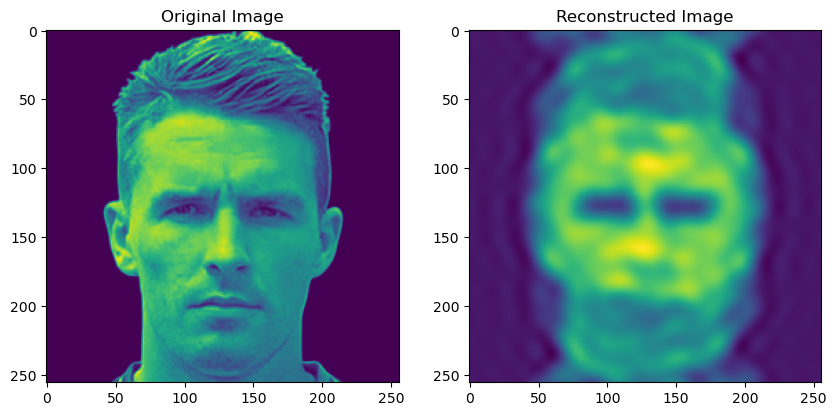

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_hat)
plt.title('Reconstructed Image')

plt.show()